In [1]:
###### Applications Lab #3-- ATOC7500 Objective Analysis - eof_analysis_cosineweighting_cartopy
###### Written by Elizabeth Maroon and Jennifer Kay, with "peer-review" by Vineel Yettella (University of Colorado)
###### last updated February 27, 2019

##LEARNING GOALS:
##1) Complete an EOF analysis using the two methods discussed in class: eigenanalysis of the covariance matrix, 
## Singular Value Decomposition (SVD). Compare and make sure you get the same answer.  See how the code works 
## to implement the matrix math in the Barnes notes.
##2) Assess the statistical significance of the results, including estimating the effective sample size (N*).
##3) Provide a qualitative description of the results: What are the eigenvalue,
##the eigenvector, and the principal component?  What do they mean physically?
## What do you learn from each one about the space-time structure of the underlying dataset?
##4) Assess influence of data preparation on EOF results. What is the influence of the seasonal cycle, 
## detrending, cosine weighting, standardizing (dividing by the standard deviation), anomalizing (removing the mean)

### GENERAL SETUP
%matplotlib inline  
# this enables plotting within notebook

#import modules
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np   # basic math library  you will type np.$STUFF  e.g., np.cos(1)
import numpy.linalg as LA
from matplotlib.gridspec import GridSpec
import timeit
import cartopy.crs as ccrs
import datetime
import scipy.stats as stats # imports stats functions https://docs.scipy.org/doc/scipy/reference/stats.html 

In [2]:
### hides code on command :). You could try it.  I found it weird - I like to see the code.
## Anyways, Neat to have as an option if you don't want to show the code...
#from IPython.display import HTML
#HTML('''<script>
#code_show=true; 
#function code_toggle() {
# if (code_show){
# $('div.input').hide();
# } else {
# $('div.input').show();
# }
# code_show = !code_show
#} 
#$( document ).ready(code_toggle);
#</script>
#The raw code for this IPython notebook is by default hidden for easier reading.
#To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
### Read in the data
#load HadISST data - Data from http://www.metoffice.gov.uk/hadobs/hadisst/data/download.html.  
filename='HadISST_sst.nc'
ds=xr.open_dataset(filename,decode_times=True)
print(ds['time'])

<xarray.DataArray 'time' (time: 1769)>
array(['1870-01-16T11:59:59.505615234', '1870-02-14T23:59:59.340820312',
       '1870-03-16T11:59:59.340820312', ..., '2017-03-16T12:00:00.000000000',
       '2017-04-16T12:00:00.000000000', '2017-05-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2017-05-16T12:00:00
Attributes:
    long_name:      Time
    standard_name:  time


In [4]:
### STEP #1 - PREPARE YOUR DATA FOR ANALYSIS

#Shift the dataset by 180 degrees to get indices for Pacific basin to be monotonically increasing
dsshift=ds.roll(longitude=180)
#dsshift2=dsshift
shiftedlon=dsshift['longitude'].values
shiftedlon[dsshift['longitude'].values<0]=dsshift['longitude'].values[dsshift['longitude'].values<0]+360
#print(shiftedlon)
dsshift.coords['longitude']=('longitude',shiftedlon)
#print(dsshift['longitude'])
lon=dsshift['longitude'].sel(longitude=slice(108,-101+360))
lat=dsshift['latitude'].sel(latitude=slice(68,20))
#time1=datetime.date(1980,1,1)
time1=datetime.date(1950,1,1)
time2=datetime.date(2017,1,1)
time=dsshift['time']

#Select only Northern Pacific temperature from 20N-70N, 108E to 101W  101+360
pacts=dsshift['sst'].sel(latitude=slice(68,20)).sel(longitude=slice(108,-101+360)) #latitude is reversed
pacts=pacts.sel(time=slice(time1,time2))
time=time.sel(time=slice(time1,time2))
print(np.shape(time))
print(np.shape(pacts))

#Set points with sea ice equal to nans so that they are not included in averaging.
nanhelp=pacts.values
#print(nanhelp[0,:,:])
#plt.contourf(nanhelp[0,:,:])
#plt.colorbar()
foo=np.where((nanhelp<=-100)|(np.isnan(nanhelp))) ## note this gives a warning because nanhelp already has nans in it (over land)
nanhelp[foo]=np.nan;  ## pull out sea ice (set at -999)
nans=np.empty(np.shape(pacts))
nans[0:len(time),:,:]=np.nansum(np.isnan(nanhelp),axis=0)[None,:,:]  ## in the time axis (axis=0) - find any times with sea ice
pacts.values[nans>0]=np.nan   ## None is the time axis dummy.  broadcasts across the dimensions.  

/Users/jkay/anaconda3/envs/culabenv/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  after removing the cwd from sys.path.


(804,)
(804, 48, 151)


/Users/jkay/anaconda3/envs/culabenv/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less_equal


In [5]:
### Check dimesions of time and pactsanom after subsetting
print(np.shape(time))
print(np.shape(pacts))

(804,)
(804, 48, 151)


In [6]:
### STEP #1 - PREPARE YOUR DATA FOR ANALYSIS (continued)

# Take anomalies - subtract the mean (keep by default)
pactsanom=pacts-pacts.mean('time');

# Remove the seasonal cycle (keep by default)
climo=pactsanom.groupby('time.month').mean('time')
pactsanom=pactsanom.groupby('time.month')-climo
#print(np.shape(pactsanom))
#print(pactsanom)

# Remove the linear trend (comment out by default)
#time1=np.arange(1,len(time)+1,1)
#print(np.shape(time1))
## calculate the slope a1 using Barnes Equation (14)
#a1=np.dot(time1-time1.mean(),np.swapaxes(pactsanom.values,0,1))/np.dot(time1-time1.mean(),time1-time1.mean());
#print(np.shape(beta))
#a1_broadcast=a1[None,:,:]*time1[:,None,None]
#print(np.shape(a1_broadcast))
#pactsanom.values=pactsanom.values-a1_broadcast;

# Standardize your data - divide by the standard deviation (keep by default)
pactsanomstd= pactsanom/(pactsanom.std('time'));

# Remove missing values, i.e., set nans = 0 (EOF analysis fails with nan!)
# setting to 0 when you are working with anomalies is equivalent to setting the value to the mean value, a decent assumption
pactsanomstd.values[np.isnan(pactsanomstd.values)]=0.0;
pactsanom.values[np.isnan(pactsanom.values)]=0.0;

/Users/jkay/anaconda3/envs/culabenv/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [7]:
### STEP #1 - PREPARE YOUR DATA FOR ANALYSIS (continued)

## cosine weighting following Hannachi et al. 2007 page 1123, not Barnes.
## we found that the SVD and eigenanalysis give same results when you weight the data matrix by sqrt(cosine(lat))
#print(lat)
pactsanomstdwgt=pactsanomstd*np.sqrt(np.cos(lat*np.pi/180))
#print(pactsanomstdwgt)

804 48 151
(804, 7248)
(804, 7248)


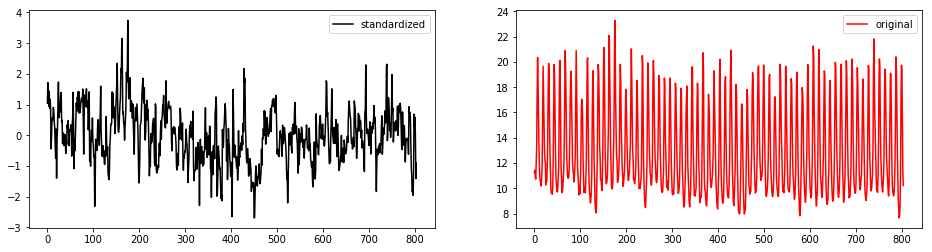

In [8]:
### STEP #1 - PREPARE YOUR DATA FOR ANALYSIS (continued)
### At the end of this first step you want two matrices ready for EOF analysis
### Y_stand = standardized data, dimensioned (time,location)
### Y = original data, dimensioned (time,location)
### everything below in the code assumes that you have Y_stand, Y defined as above

#flatten the lat,lon in the array so that you have an array dimensioned (time,location)
a,b,c=np.shape(pactsanom.values)  ## have axis sizes for later (a, b, c)
Y_stand=pactsanomstdwgt.values.reshape(a,b*c);
Y=pactsanom.values.reshape(a,b*c);
print(a,b,c)
print(np.shape(Y_stand))
print(np.shape(Y))

#plot the standardized and original time series for one location -- Look at your data!!
f=plt.figure(figsize=(16,4))
gs=GridSpec(1,2)
plt.subplot(gs[0,0])
plt.plot(Y_stand[:,4012],label='standardized',color='black');
plt.legend()
plt.subplot(gs[0,1])
plt.plot(pacts.values.reshape(a,b*c)[:,4012],label='original',color='red');
plt.legend()

In [9]:
### STEP #2 - Calculate the EOFs -- Using eigenanalysis of the covariance matrix (the np.linalg.eig method)

#calculate covariance matrix
C = 1./np.size(Y_stand,axis = 0)*np.dot(np.transpose(Y_stand),Y_stand) ## Barnes Chapter 3 Equation 7
print(np.shape(Y_stand))
print(np.shape(C))

#get eigenvalues and eigenvectors - linear algebra module method - will take a couple of minutes
start_time = timeit.default_timer()
lam, E = LA.eig(C) ## Barnes Chapter 3 Equation 42
elapsed = timeit.default_timer() - start_time
print('Time elapsed in LA eigenvalue method: ',elapsed, 'seconds')

#order by eigenvalues and eigenvectors by eigenvalues
ii=np.flipud(np.argsort(lam))
lam=lam[ii]
E=E[:,ii]

(804, 7248)
(7248, 7248)
Time elapsed in LA eigenvalue method:  71.49053426110186 seconds


In [10]:
### STEP #2 - Calculate the EOFs -- Using Singular Value Decomposition (SVD) (the np.linalg SVD method)
### Why is this method so much faster?
start_time = timeit.default_timer()
u,s,v=LA.svd(Y_stand)  ## Barnes Chapter 3 Equation (65)
elapsed = timeit.default_timer() - start_time
print('Time elapsed in LA SVD method: ',elapsed,' seconds')

Time elapsed in LA SVD method:  11.128557779826224  seconds


804
(804,)
lag1 autocorrelation from np.correlate: 0.854


/Users/jkay/anaconda3/envs/culabenv/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


<ErrorbarContainer object of 3 artists>

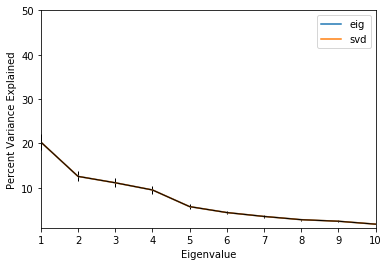

In [11]:
### STEP #3 - Plot the eigenvalues from both methods including errors bars following North et al. 1982.

# convert eigenvalues to percent variance explained
pve = 100.*np.abs(lam)/np.sum(np.abs(lam))
pve2 = 100.*np.abs(s**2)/np.sum(np.abs(s**2))
##print(pve2[0:10]-pve[0:10])

f=plt.figure()
plt.plot(np.arange(1,len(pve)+1),pve,label='eig');
plt.plot(np.arange(1,len(pve2)+1),pve2,label='svd')
plt.ylim([1,50])
plt.xlim([1,10])
plt.ylabel('Percent Variance Explained')
plt.xlabel('Eigenvalue')
plt.legend()

Nstar = np.size(Y_stand,axis = 0) ## assume all data is independent (not a great assumption, how do we do better?)
print(Nstar)
###  could for example - find the effective sample size using the average of all data
tseries=np.nanmean(np.nanmean(pacts,axis=2),axis=1)  ## warning from land nans, ignore it!
print(np.shape(tseries))
sigma=np.std(tseries)  ## calculate the standard deviation
mean=np.mean(tseries)  ## calculate the mean
N=len(tseries)         ## calculate the length of the timeseries
lag=1
t1_m=tseries[0:-1*lag]-mean
t2_m=tseries[lag:]-mean
alpha=np.correlate(t1_m,t2_m,mode='valid')/(N-lag)/(sigma**2)
print('lag1 autocorrelation from np.correlate:',round(alpha[0],3))
### Calculate the effective sample size (Nstar) for this data
### To estimate the number of independent samples - use Chapter 2 Barnes Eq. 88
Nstar=np.round((1-alpha)/(1+alpha)*N,0)
eb = pve*np.sqrt(2./Nstar)  ## North 1982, Barnes Chapter 3 Equation 80
plt.errorbar(np.arange(1,np.size(pve)+1.),pve,yerr = eb/2, xerr = None, linewidth = 1, color = 'black')

In [12]:
### STEP 4 - Plot the first EOF pattern and PC timeseries 

# select an EOF
eof_num=1

# Find the eigenvector (e1) associated with "eof_num" from the eigenanalysis method
e1 = E[:,eof_num-1]
print(np.shape(e1))

# Calculate the principal component (z1) associated with "eof_num" from the eigenanalysis method
z1 = np.dot(Y_stand,e1)  ## Barnes Chapter 3 Eq. (50)
## standardize it
z1 = (z1-np.mean(z1))/np.std(z1)  
print(np.shape(z1))

# Find the eigenvector (e1_svd) associated with "eof_num" from the SVD method
print(np.shape(v),np.shape(s),np.shape(u))
e1_svd = (v[eof_num-1,:]).reshape(b,c)
print(np.shape(e1_svd))

# Calculate the principal component (z1_svd) associated with "eof_num" from the SVD method
z1_svd = u[:,eof_num-1]*(s[eof_num-1])
## standardize it
z1_svd = (z1_svd-np.mean(z1_svd))/np.std(z1_svd)  
print(np.shape(z1_svd))

(7248,)
(804,)
(7248, 7248) (804,) (804, 804)
(48, 151)
(804,)


Text(0.5, 1.0, 'Principal Component (amplitude) from SVD')

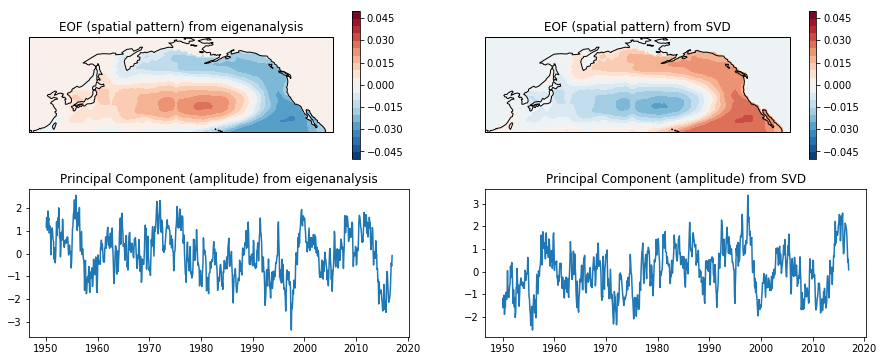

In [13]:
### Make a 4-panel plot showing the eigenvector (spatial pattern) and principal component (amplitude)

f=plt.figure(figsize=(15,6))
gs=GridSpec(2,2)

ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=180))
#levels=np.arange(-0.1,0.11,0.01)
levels=np.arange(-0.05,0.051,0.005)
CS=ax.contourf(lon,lat,e1.reshape(b,c),levels,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]],ccrs.PlateCarree())
ax.coastlines()
plt.title('EOF (spatial pattern) from eigenanalysis')
plt.colorbar(CS)
plt.subplot(gs[1,0])
plt.plot(time,(z1))
plt.title('Principal Component (amplitude) from eigenanalysis')
##plt.xlim([0,900])  ## when the first EOF is the seasonal cycle
ax=plt.subplot(gs[0,1],projection=ccrs.PlateCarree(central_longitude=180))
levels=levels+1e-14 ### cartopy weirdness not explained but at least it makes plots :)
CS=ax.contourf(lon,lat,np.real(e1_svd),levels,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]],ccrs.PlateCarree())
ax.coastlines()
plt.title('EOF (spatial pattern) from SVD')
plt.colorbar(CS)
plt.subplot(gs[1,1])
plt.plot(time,(z1_svd))
plt.title('Principal Component (amplitude) from SVD')

In [14]:
### STEP 5) Regress the data (unweighted data if applicable) onto standardize values of the PC 
### for eof_num above

# calculate d for plotting in physical units, not standardized/weighted units.
## d1 is in physical units (in this case degrees) and denotes the anomaly associated with 1 standard deviation
## of z1 (principal component, time variation in this case)
#print(np.max(X.values))
#print(np.min(X.values))
#print(np.shape(Yorig))
#print(np.shape(np.transpose(z)))
d1 = (1./np.size(Y,axis=0))*np.dot(np.transpose(z1),Y)   ## Barnes Chapter 3 Equation (79)
#print(np.shape(d1))
d1plot = d1.reshape(b,c)  ### this is the reshaped eigenvector to plot
#print(np.shape(d1plot))
print(min(d1))
print(max(d1))
      
# calculate d for plotting in standardized/weighted units
## d1s is in standardized units (in other words, no units) and denotes the anomaly associated with 1 standard deviation
## of z1 (principal component, time variation in this case)
d1s = (1./np.size(Y_stand,axis=0))*np.dot(np.transpose(z1),Y_stand)
#print(np.shape(d1))
d1splot = d1s.reshape(b,c)  ### this is the reshaped eigenvector to plot
#print(np.shape(d1splot))
print(min(d1s))
print(max(d1s))

-0.7946283
0.5471947
-0.7972251
0.68409383


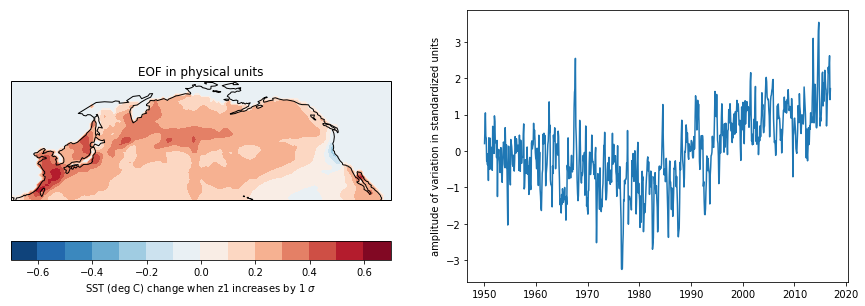

In [17]:
### Make a plot of the EOF in physical units and associated PC
f=plt.figure(figsize=(15,5))
gs=GridSpec(1,2)
levels2=np.arange(-0.7,0.71,0.1)
levels2=levels2+1e-14 ### cartopy weirdness again
ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=180))
CS=ax.contourf(lon,lat,d1plot,levels2,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.coastlines()
cb=plt.colorbar(CS,orientation='horizontal')
cb.set_label('SST (deg C) change when z1 increases by 1 $\sigma$')
plt.title('EOF in physical units')
plt.subplot(gs[0,1])
plt.plot(time,z1)
plt.ylabel('amplitude of variation in standardized units');

(7248,)
(804,)
(7248, 7248) (804,) (804, 804)
(48, 151)
(804,)
-0.26699558
0.5633093
-0.24085622
0.58108884
(151, 48)


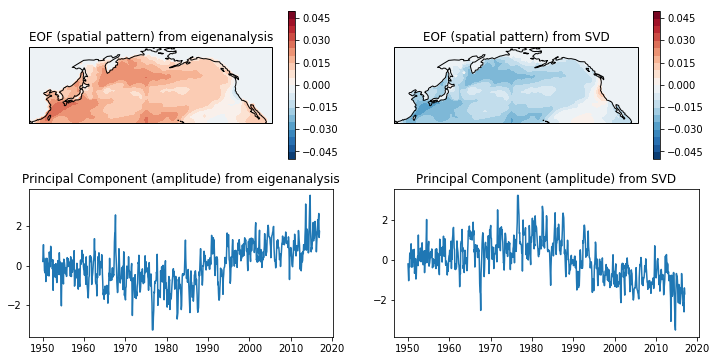

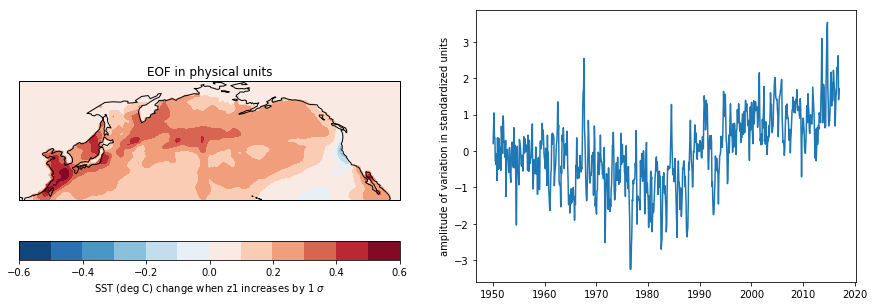

In [16]:
### STEP 4 and 5 for the second EOF  

#let's look at second eof
eof_num=2

# Find the eigenvector (e1) associated with "eof_num" from the eigenanalysis method
e1 = E[:,eof_num-1]
print(np.shape(e1))

# Calculate the principal component (z1) associated with "eof_num" from the eigenanalysis method
z1 = np.dot(Y_stand,e1)  ## Barnes Chapter 3 Eq. (50)
## standardize it
z1 = (z1-np.mean(z1))/np.std(z1)  
print(np.shape(z1))

# Find the eigenvector (e1_svd) associated with "eof_num" from the SVD method
print(np.shape(v),np.shape(s),np.shape(u))
e1_svd = (v[eof_num-1,:]).reshape(b,c)
print(np.shape(e1_svd))

# Calculate the principal component (z1_svd) associated with "eof_num" from the SVD method
z1_svd = u[:,eof_num-1]*(s[eof_num-1])
## standardize it
z1_svd = (z1_svd-np.mean(z1_svd))/np.std(z1_svd)  
print(np.shape(z1_svd))

### Make a 4-panel plot showing the eigenvector (spatial pattern) and principal component (amplitude)
### note: (need to redo in cartopy)

f=plt.figure(figsize=(12,6))
gs=GridSpec(2,2)
ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=180))
#levels=np.arange(-0.1,0.11,0.01)
levels=np.arange(-0.05,0.051,0.005)
levels=levels+1e-14 ##cartopy weirdness
CS=ax.contourf(lon,lat,e1.reshape(b,c),levels,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.coastlines()
plt.title('EOF (spatial pattern) from eigenanalysis')
plt.colorbar(CS)
plt.subplot(gs[1,0])
plt.plot(time,(z1))
plt.title('Principal Component (amplitude) from eigenanalysis')
#plt.xlim([0,900])  ## when the first EOF is the seasonal cycle
ax=plt.subplot(gs[0,1],projection=ccrs.PlateCarree(central_longitude=180))
CS=ax.contourf(lon,lat,e1_svd,levels,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.coastlines()
plt.title('EOF (spatial pattern) from SVD')
plt.colorbar(CS)
plt.subplot(gs[1,1])
plt.plot(time,(z1_svd))
plt.title('Principal Component (amplitude) from SVD')

# calculate d for plotting in physical units, not standardized/weighted units.
## d1 is in physical units (in this case degrees) and denotes the anomaly associated with 1 standard deviation
## of z1 (principal component, time variation in this case)
#print(np.max(X.values))
#print(np.min(X.values))
#print(np.shape(Yorig))
#print(np.shape(np.transpose(z)))
d1 = (1./np.size(Y,axis=0))*np.dot(np.transpose(z1),Y)   ## Barnes Chapter 3 Equation (79)
#print(np.shape(d1))
d1plot = d1.reshape(b,c)  ### this is the reshaped eigenvector to plot
#print(np.shape(d1plot))
print(min(d1))
print(max(d1))
      
# calculate d for plotting in standardized/weighted units
## d1s is in standardized units (in other words, no units) and denotes the anomaly associated with 1 standard deviation
## of z1 (principal component, time variation in this case)
d1s = (1./np.size(Y_stand,axis=0))*np.dot(np.transpose(z1),Y_stand)
#print(np.shape(d1))
d1splot = d1s.reshape(b,c)  ### this is the reshaped eigenvector to plot
#print(np.shape(d1splot))
print(min(d1s))
print(max(d1s))

f=plt.figure(figsize=(15,5))
gs=GridSpec(1,2)
levels2=np.arange(-0.6,0.61,0.1)
ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=180))
print(np.shape(np.transpose(d1.reshape(b,c))))
CS=ax.contourf(lon,lat,d1plot,levels2,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.coastlines()
#CS=m.contourf(x,y,d1plot,levels2,cmap=plt.cm.RdBu_r)
#m.drawcoastlines()
cb=plt.colorbar(CS,orientation='horizontal')
cb.set_label('SST (deg C) change when z1 increases by 1 $\sigma$')
plt.title('EOF in physical units')

plt.subplot(gs[0,1])
plt.plot(time,z1)
plt.ylabel('amplitude of variation in standardized units');